In [52]:
import torch
import random
from tqdm import tqdm
from torch.utils.data import Dataset
import math
import pandas as pd #only used for viewing the datset
import numpy as np
import os
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow import keras

from matplotlib import cm
from matplotlib import pyplot as plt
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" ## since my kernel always breaks down suddenly , I have to add this line

import warnings
warnings.filterwarnings('ignore')


In [53]:
class mandelbrotDataSet: 
    """   
    this is the datset that the NN will be trained on!
    
    The following init function computes the Mandelbrot set in a half-width square area centered at (x_enter,y_center). 
    This square area has an x-coordinate range of x_center±semi_width and a y-coordinate range of y_center±semi_width.
    
    Output is a two-dimensional matrix with the value of the maximum number of iterations per c without exceeding 
    a threshold, which is used here for map different colors. So, the output can use to draw image directly. 
    
    """
    def __init__(self,  x_center=0.2,y_center=0.5,semi_width=0.2,size = 600, max_depth = 50):
        ## N = size * size elements, default is a N= 600 * 600 =360000 elements set.
        self.size = size      
        self.max_depth = max_depth
        self.outputs = []
        self.x_from,self.x_to,self.y_from,self.y_to = x_center-semi_width,x_center+semi_width,\
                          y_center-semi_width,y_center+semi_width
        
        ## np.ogrid() is similar to np.linspace() but return two-dimensional array
        self.y,self.x = np.ogrid[self.y_from:self.y_to:self.size*1j,self.x_from:self.x_to:self.size*1j]
        
        ## the value of matrix c is complex, and size of c is size * size, default is 600*600
        self.c = self.x + self.y*1j
        print("c.shape:",self.c.shape,"x.shape:",self.x.shape,"y.shape:",self.y.shape)
        
        ## a two dimensional matrix with length and width eaqual to self.size
        self.outputs=np.frompyfunc(self.f,1,1)(self.c).astype(np.float)       
    
    def f(self, a):
        """ Itterates up to max depth to check if a complex number belongs to the madelbrot set or not."""
        z = 0
        ## The maximum escape time is max_depth-1 
        for n in range(1, self.max_depth):
            z = z ** 2 + a
            if abs(z) > 2:
                return n ## the iterate times is used to map colors
        return n 

    def get_X_and_Y(self):
        
        xc=np.squeeze(self.c.real.reshape(1,-1))## get real part and reshape to a vector
        yc=np.squeeze(self.c.imag.reshape(1,-1))## get imaginary part and reshape to a vector
        color=np.squeeze(self.outputs.reshape(1,-1))
        label=(color==self.max_depth-1)
        return np.array(list(zip(xc,yc))),label,color
            
    def view(self):
        dataframe = pd.DataFrame(data = [], columns = ["x","y", "Belongs?","color"])
        xc=np.squeeze(self.c.real.reshape(1,-1))## get real part and reshape to a vector
        yc=np.squeeze(self.c.imag.reshape(1,-1))## get imaginary part and reshape to a vector
        dataframe.x=xc
        dataframe.y=yc
        color=np.squeeze(self.outputs.reshape(1,-1))# get outputs and reshape to a vector
        dataframe.color=color
        dataframe["Belongs?"]= (color==self.max_depth-1)

        return dataframe       


In [54]:
mandelbrot = mandelbrotDataSet(size=600) 
X, Y,Color = mandelbrot.get_X_and_Y() 

c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)


In [55]:
class Para: ## A Para class with only a name is used to store global parameters
    pass

para = Para()
## You can change the color of the image by changing the idxColorMap
para.idxColorMap = 1
## the total color type is in cmaps list
para.cmaps = [ 'ocean', 'gist_earth', 'terrain', 'gist_stern',
         'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg','gist_rainbow',
         'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']


def drawImage(ds,cmaps):
    para.fig = plt.figure(figsize=(12,6),dpi=100)
    para.ax0 = plt.subplot(121)
    para.ax0.set_axis_off()## Hide the coordinates of the subgraph
    c = cm.get_cmap(cmaps[para.idxColorMap%len(cmaps)])
    ## The cmap function inside imshow() corresponds to a color map object, which is responsible for converting the value of the 
    ## element (i.e., the escape time of the complex c) to the corresponding color.
    para.ax0.imshow(ds,cmap=c)

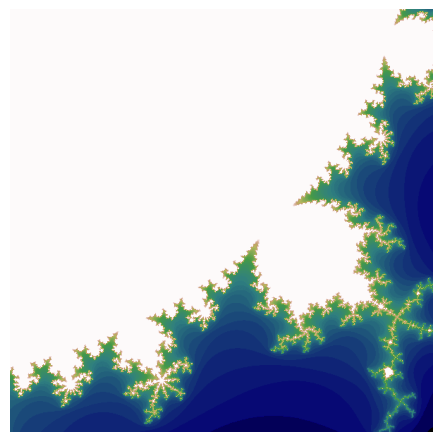

In [56]:
drawImage(mandelbrot.outputs,para.cmaps)

### Model Input data

In [57]:
X_train, X_test = X[:math.ceil(X.shape[0] * 0.8)], X[math.ceil(X.shape[0] * 0.8):]
Y_train, Y_test = Y[:math.ceil(Y.shape[0] * 0.8)], Y[math.ceil(Y.shape[0] * 0.8):]
Color_train, Color_test = Color[:math.ceil(Y.shape[0] * 0.8)], Color[math.ceil(Y.shape[0] * 0.8):]

In [58]:
new_x, new_Y, new_color = mandelbrot.get_X_and_Y() 
shuffled_X, shuffled_Color = shuffle(new_x, new_color, random_state = 42)
new_X_train, new_X_test = shuffled_X[:math.ceil(shuffled_X.shape[0] * 0.5)], shuffled_X[math.ceil(shuffled_X.shape[0] * 0.5):]
new_Color_train, new_Color_test = shuffled_Color[:math.ceil(shuffled_Color.shape[0] * 0.5)], shuffled_Color[math.ceil(shuffled_Color.shape[0] * 0.5):]

In [71]:
def view_model_on_image(model):
    dataset = mandelbrotDataSet() 
    X,Label,Color = dataset.get_X_and_Y()
    predictions = model.predict(X)
    predictions_as_classes = np.argmax(predictions, axis = 1)
    drawImage(predictions_as_classes.reshape(600,-1),para.cmaps)

def view_history(history):
    pd.DataFrame(history.history).plot(figsize = (8, 8))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()


In [72]:
def get_model_1():
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape  = [2, 1]))  
    model.add(keras.layers.Dense(300, activation = "relu")) 
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(50, activation = "softmax")) 
    print(model.summary())
    return model

def get_model_2():
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape  = [2, 1]))  
    model.add(keras.layers.Dense(300, activation = "relu")) 
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu")) 
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(50, activation = "softmax")) 
    print(model.summary())
    return model

def get_model_3():
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape  = [2, 1]))  
    model.add(keras.layers.Dense(300, activation = "relu")) 
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu")) 
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu")) 
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu")) 
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu")) 
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu")) 
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(50, activation = "softmax")) 
    print(model.summary())
    return model


### Comparing Models with SGD optimiser, learning rate = 0.01, epcohs = 20

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 2)                 0         
                                                                 
 dense_24 (Dense)            (None, 300)               900       
                                                                 
 dense_25 (Dense)            (None, 300)               90300     
                                                                 
 dense_26 (Dense)            (None, 50)                15050     
                                                                 
Total params: 106,250
Trainable params: 106,250
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
5625/5625 [==============================] - 8s 1ms/step - loss: 1.6089 - accuracy: 0.6571 - val_loss: 1.3671 - val_accuracy: 0.6791
Epoch 2/20
5625/5625 [=========

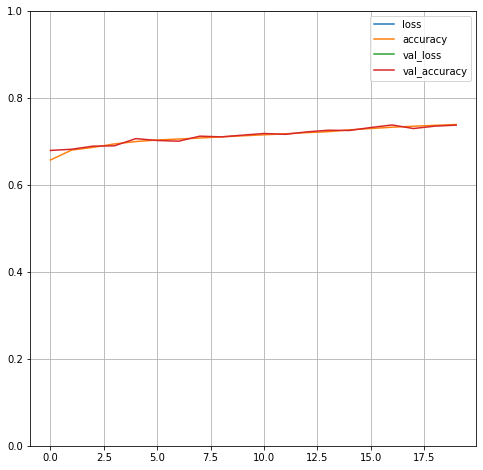


c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 5s 453us/step


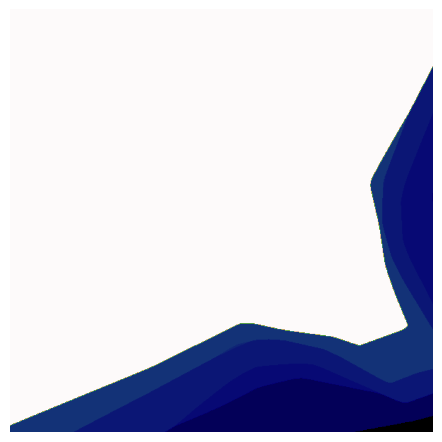

In [73]:
model1_adam_20 = get_model_1()


SGD = tf.keras.optimizers.SGD(learning_rate = 0.01)
 
model1_adam_20.compile(loss = "sparse_categorical_crossentropy", optimizer = SGD, metrics = ["accuracy"]) 

history = model1_adam_20.fit(new_X_train, new_Color_train, epochs = 20, validation_data = (new_X_test, new_Color_test))

view_history(history)

print()

view_model_on_image(model1_adam_20)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 2)                 0         
                                                                 
 dense_27 (Dense)            (None, 300)               900       
                                                                 
 dense_28 (Dense)            (None, 300)               90300     
                                                                 
 dense_29 (Dense)            (None, 300)               90300     
                                                                 
 dense_30 (Dense)            (None, 300)               90300     
                                                                 
 dense_31 (Dense)            (None, 300)               90300     
                                                                 
 dense_32 (Dense)            (None, 50)               

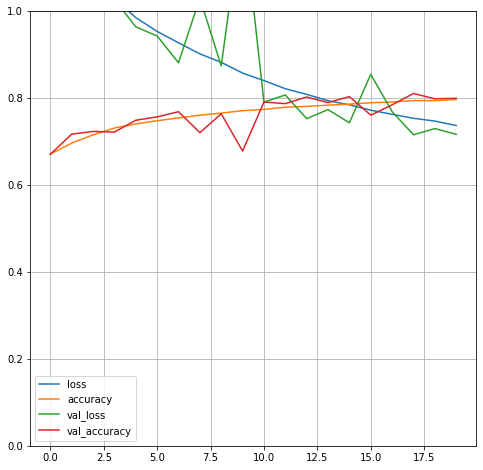


c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 7s 658us/step


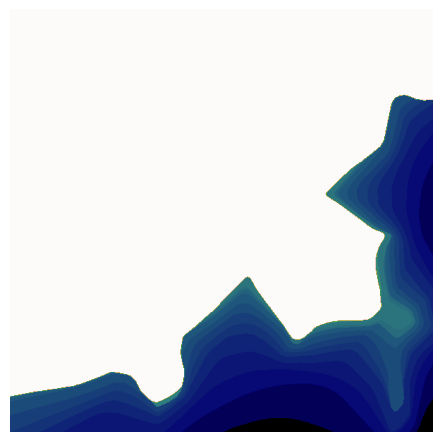

In [74]:
model2_adam_20 = get_model_2()


SGD = tf.keras.optimizers.SGD(learning_rate = 0.01)

model2_adam_20.compile(loss = "sparse_categorical_crossentropy", optimizer = SGD, metrics = ["accuracy"]) 

history = model2_adam_20.fit(new_X_train, new_Color_train, epochs = 20, validation_data = (new_X_test, new_Color_test))

view_history(history)

print()

view_model_on_image(model2_adam_20)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 2)                 0         
                                                                 
 dense_33 (Dense)            (None, 300)               900       
                                                                 
 dense_34 (Dense)            (None, 300)               90300     
                                                                 
 dense_35 (Dense)            (None, 300)               90300     
                                                                 
 dense_36 (Dense)            (None, 300)               90300     
                                                                 
 dense_37 (Dense)            (None, 300)               90300     
                                                                 
 dense_38 (Dense)            (None, 300)              

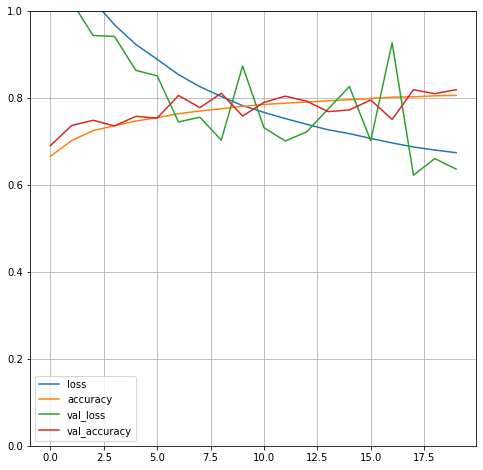


c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 13s 1ms/step


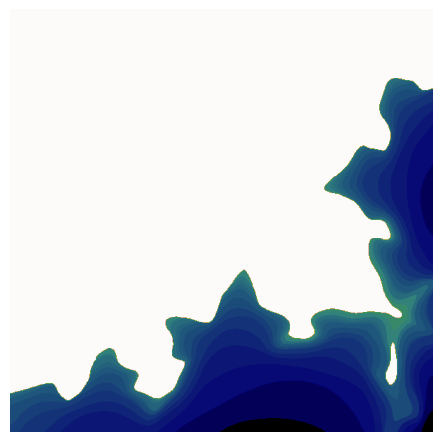

In [75]:
model3_adam_20 = get_model_3()

SGD = tf.keras.optimizers.SGD(learning_rate = 0.01)

model3_adam_20.compile(loss = "sparse_categorical_crossentropy", optimizer = SGD, metrics = ["accuracy"]) 

history = model3_adam_20.fit(new_X_train, new_Color_train, epochs = 20, validation_data = (new_X_test, new_Color_test))

view_history(history)

print()

view_model_on_image(model3_adam_20)

### Looking at Model 2 with SGD and learning rate of 0.1

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_11 (Flatten)        (None, 2)                 0         
                                                                 
 dense_52 (Dense)            (None, 300)               900       
                                                                 
 dense_53 (Dense)            (None, 300)               90300     
                                                                 
 dense_54 (Dense)            (None, 300)               90300     
                                                                 
 dense_55 (Dense)            (None, 300)               90300     
                                                                 
 dense_56 (Dense)            (None, 300)               90300     
                                                                 
 dense_57 (Dense)            (None, 50)              

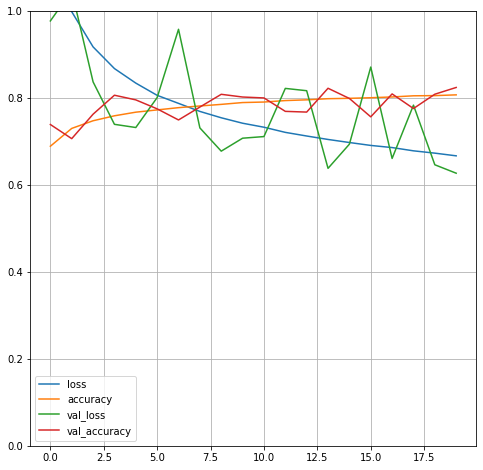


c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 8s 679us/step


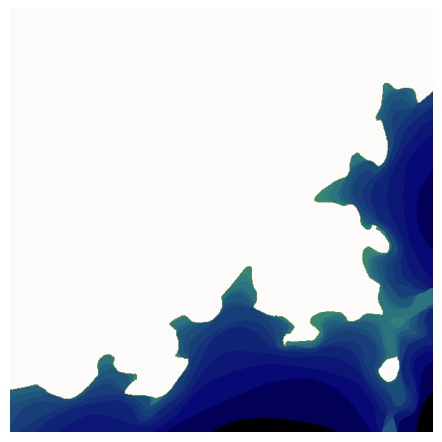

In [77]:
model2_adam_20 = get_model_2()

SGD = tf.keras.optimizers.SGD(learning_rate = 0.1)

model2_adam_20.compile(loss = "sparse_categorical_crossentropy", optimizer = SGD, metrics = ["accuracy"]) 

history = model2_adam_20.fit(new_X_train, new_Color_train, epochs = 20, validation_data = (new_X_test, new_Color_test))

view_history(history)

print()

view_model_on_image(model2_adam_20)

### Model 2 with ADAM and learning rate 0.1

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 2)                 0         
                                                                 
 dense_64 (Dense)            (None, 300)               900       
                                                                 
 dense_65 (Dense)            (None, 300)               90300     
                                                                 
 dense_66 (Dense)            (None, 300)               90300     
                                                                 
 dense_67 (Dense)            (None, 300)               90300     
                                                                 
 dense_68 (Dense)            (None, 300)               90300     
                                                                 
 dense_69 (Dense)            (None, 50)              

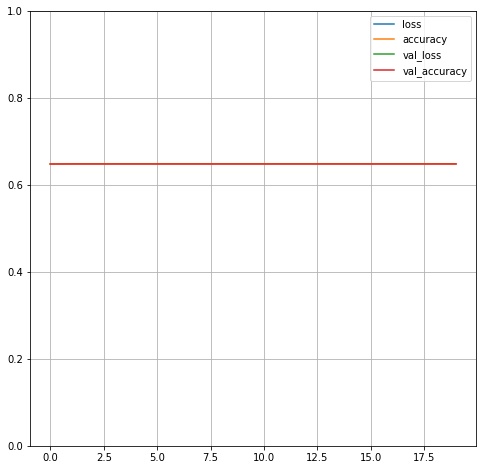


c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 8s 671us/step


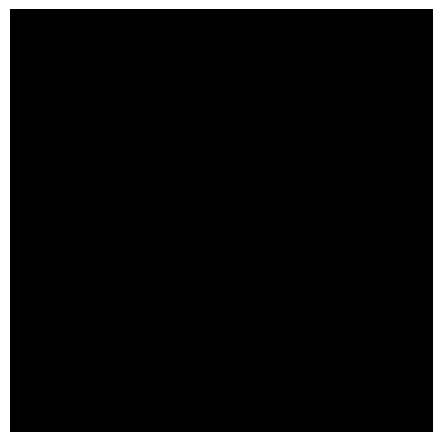

In [79]:
model2_adam_20 = get_model_2()

adam = tf.keras.optimizers.Adam(learning_rate = 0.1)

model2_adam_20.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = ["accuracy"]) 

history = model2_adam_20.fit(new_X_train, new_Color_train, epochs = 20, validation_data = (new_X_test, new_Color_test))

view_history(history)

print()

view_model_on_image(model2_adam_20)

### Gnarly Model with new architecture, adam, lr = 0.001 and epochs = 150

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_14 (Flatten)        (None, 2)                 0         
                                                                 
 dense_70 (Dense)            (None, 300)               900       
                                                                 
 dense_71 (Dense)            (None, 300)               90300     
                                                                 
 dense_72 (Dense)            (None, 300)               90300     
                                                                 
 dense_73 (Dense)            (None, 300)               90300     
                                                                 
 dense_74 (Dense)            (None, 300)               90300     
                                                                 
 dense_75 (Dense)            (None, 50)              

5625/5625 [==============================] - 13s 2ms/step - loss: 0.5058 - accuracy: 0.8500 - val_loss: 0.4896 - val_accuracy: 0.8593
Epoch 48/150
5625/5625 [==============================] - 13s 2ms/step - loss: 0.5086 - accuracy: 0.8496 - val_loss: 0.5256 - val_accuracy: 0.8427
Epoch 49/150
5625/5625 [==============================] - 13s 2ms/step - loss: 0.5060 - accuracy: 0.8504 - val_loss: 0.5181 - val_accuracy: 0.8483
Epoch 50/150
5625/5625 [==============================] - 13s 2ms/step - loss: 0.5079 - accuracy: 0.8502 - val_loss: 0.5098 - val_accuracy: 0.8462
Epoch 51/150
5625/5625 [==============================] - 13s 2ms/step - loss: 0.5072 - accuracy: 0.8503 - val_loss: 0.5436 - val_accuracy: 0.8396
Epoch 52/150
5625/5625 [==============================] - 13s 2ms/step - loss: 0.5063 - accuracy: 0.8507 - val_loss: 0.5160 - val_accuracy: 0.8497
Epoch 53/150
5625/5625 [==============================] - 13s 2ms/step - loss: 0.5078 - accuracy: 0.8504 - val_loss: 0.4692 - val_a

Epoch 103/150
5625/5625 [==============================] - 13s 2ms/step - loss: 0.4880 - accuracy: 0.8577 - val_loss: 0.4646 - val_accuracy: 0.8654
Epoch 104/150
5625/5625 [==============================] - 13s 2ms/step - loss: 0.4878 - accuracy: 0.8566 - val_loss: 0.4406 - val_accuracy: 0.8751
Epoch 105/150
5625/5625 [==============================] - 13s 2ms/step - loss: 0.4908 - accuracy: 0.8555 - val_loss: 0.4761 - val_accuracy: 0.8608
Epoch 106/150
5625/5625 [==============================] - 13s 2ms/step - loss: 0.5027 - accuracy: 0.8548 - val_loss: 0.5589 - val_accuracy: 0.8432
Epoch 107/150
5625/5625 [==============================] - 13s 2ms/step - loss: 0.4856 - accuracy: 0.8576 - val_loss: 0.4488 - val_accuracy: 0.8710
Epoch 108/150
5625/5625 [==============================] - 13s 2ms/step - loss: 0.4830 - accuracy: 0.8579 - val_loss: 0.5036 - val_accuracy: 0.8512
Epoch 109/150
5625/5625 [==============================] - 14s 2ms/step - loss: 0.4885 - accuracy: 0.8571 - val_

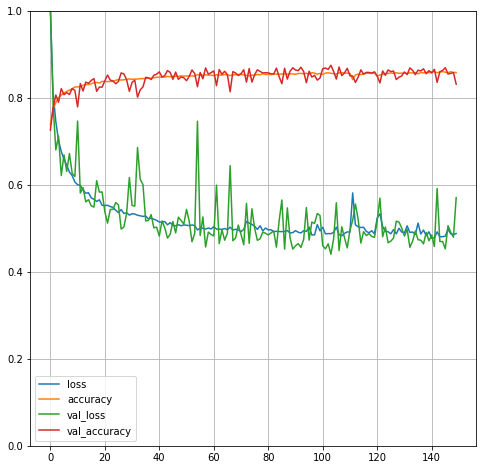


c.shape: (600, 600) x.shape: (1, 600) y.shape: (600, 1)
11250/11250 [==============================] - 8s 675us/step


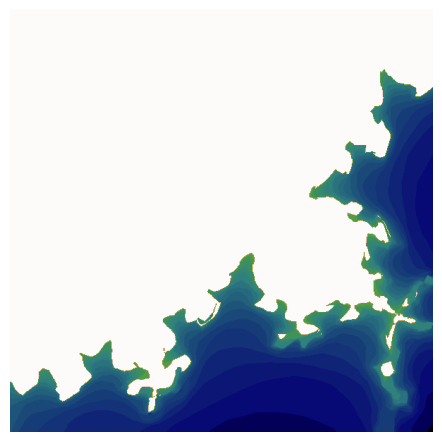

In [80]:
def super_model():
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape  = [2, 1]))  
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(300, activation = "relu"))
    model.add(keras.layers.Dense(50, activation = "softmax")) 
    print(model.summary())
    return model


super_model = get_model_2()

adam = tf.keras.optimizers.Adam(learning_rate = 0.001)

super_model.compile(loss = "sparse_categorical_crossentropy", optimizer = adam, metrics = ["accuracy"]) 

history = super_model.fit(new_X_train, new_Color_train, epochs = 150, validation_data = (new_X_test, new_Color_test))

view_history(history)

print()

view_model_on_image(super_model)